# Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal componant analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading. We can also see which factors are most important by their eiganvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

## Load Data

In [2]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt

In [3]:
rpe_df = pd.read_csv('./raw_data/rpe.csv')
rpe_df.head()


,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
0,2018-07-21,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all
1,2018-07-21,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
2,2018-07-21,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all
3,2018-07-20,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely
4,2018-07-20,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely


In [4]:
print(rpe_df.shape)

indexNames = rpe_df[ (rpe_df['PlayerID'] < 18) | (rpe_df['PlayerID'] > 21) ]
print(indexNames.shape)

(8860, 14)
(8860, 14)


To start with, we have 8860 wellness observations.

## Cleaning Data

In [5]:
print(len(rpe_df) - rpe_df['Training'].count())
rpe_df = rpe_df[~ rpe_df['SessionType'].isna()]
print(len(rpe_df))
print(rpe_df[rpe_df['SessionType'].isna()].shape)
print(rpe_df[rpe_df['Duration'].isna()].shape)
print(rpe_df[rpe_df['RPE'].isna()].shape)
print(rpe_df[rpe_df['SessionLoad'].isna()].shape)
print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['DailyLoad'].fillna(method='ffill')
rpe_df['AcuteLoad'] = rpe_df.groupby(['Date','PlayerID'])['AcuteLoad'].fillna(method='ffill')
rpe_df['ChronicLoad'] = rpe_df.groupby(['Date','PlayerID'])['ChronicLoad'].fillna(method='ffill')
rpe_df['AcuteChronicRatio'] = rpe_df.groupby(['Date','PlayerID'])['AcuteChronicRatio'].fillna(method='ffill')
print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)
print(rpe_df.head())

0
7621
(0, 14)
(0, 14)
(0, 14)
(0, 14)
(4472, 14)
(4472, 14)
(4472, 14)
(0, 14)
(0, 14)
(0, 14)
         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0      446.0      323.1       303.25               1.07   
2        243.0      446.0      323.1       303.25               1.07   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0      534.0      256.3       344.18               0.74   

   ObjectiveRating  FocusRating BestOutOfMyself  


In [6]:
for s in ['ObjectiveRating', 'FocusRating', 'BestOutOfMyself']:
    isnull = rpe_df[s].isnull()
    sample = rpe_df[s].dropna().sample(isnull.sum(), replace=True).values
    rpe_df.loc[isnull, s] = sample
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0      446.0      323.1       303.25               1.07   
2        243.0      446.0      323.1       303.25               1.07   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0      534.0      256.3       344.18               0.74   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              8.0          9.0      Not at all  
1              7.0          9.0      Not at al

In [7]:
rpe_df['BestOutOfMyself'].value_counts()

Absolutely    6069
Not at all    1080
Somewhat       472
Name: BestOutOfMyself, dtype: int64

In [8]:
print(rpe_df.head())
rpe_df['BestOutOfMyself'] = rpe_df['BestOutOfMyself'].map({'Absolutely': 3, 'Not at all': 0, 'Somewhat': 1})
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0      446.0      323.1       303.25               1.07   
2        243.0      446.0      323.1       303.25               1.07   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0      534.0      256.3       344.18               0.74   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              8.0          9.0      Not at all  
1              7.0          9.0      Not at al

## Factor Analysis

In [9]:
print(rpe_df.head())
rpe_df['SessionType'].value_counts()
rpe_df['Training'] = rpe_df['Training'].map({'Yes': 1, 'No': 0})

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0      446.0      323.1       303.25               1.07   
2        243.0      446.0      323.1       303.25               1.07   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0      534.0      256.3       344.18               0.74   

   ObjectiveRating  FocusRating  BestOutOfMyself  
0              8.0          9.0                0  
1              7.0          9.0             

AttributeError: 'DataFrame' object has no attribute 'get_dummies'

We still need to drop date and player id before I make the factor analysis dataset.

In [18]:
df_with_dummies = pd.get_dummies( rpe_df, columns = ['SessionType'] )
print(df_with_dummies.head())

         Date  PlayerID  Training  Duration  RPE  SessionLoad  DailyLoad  \
0  2018-07-21        13         1       5.0  0.0          0.0      446.0   
1  2018-07-21        13         1      29.0  7.0        203.0      446.0   
2  2018-07-21        13         1      27.0  9.0        243.0      446.0   
3  2018-07-20        11         1      36.0  6.0        216.0      534.0   
4  2018-07-20        11         1      36.0  8.0        288.0      534.0   

   AcuteLoad  ChronicLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0      323.1       303.25               1.07              8.0          9.0   
1      323.1       303.25               1.07              7.0          9.0   
2      323.1       303.25               1.07             10.0          8.0   
3      256.3       344.18               0.74              9.0         10.0   
4      256.3       344.18               0.74              9.0         10.0   

   BestOutOfMyself  SessionType_Combat  SessionType_Conditioning  \
0     

### Adequacy Tests

Before we perform any partiular tests for suitability, we should make sure there are not any columns that are correlated in our dataset.

In [19]:
df_with_dummies.corr()

,PlayerID,Training,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,SessionType_Combat,SessionType_Conditioning,SessionType_Game,SessionType_Mobility/Recovery,SessionType_Skills,SessionType_Speed,SessionType_Strength
PlayerID,1.000000,0.014194,-0.067921,-0.085777,-0.099765,-0.054533,-0.066193,-0.076453,0.040733,-0.019190,0.004077,-0.069874,0.005324,-0.009299,0.004664,0.089955,-0.013767,-0.020560,-0.036050
Training,0.014194,1.000000,0.010986,-0.004326,0.006028,0.016651,0.006021,-0.009958,0.009424,-0.000692,0.001042,-0.005690,0.001847,-0.030176,0.002914,0.004432,0.006507,0.005062,0.006623
Duration,-0.067921,0.010986,1.000000,0.254596,0.797332,0.369132,0.211553,0.073831,0.132035,-0.009673,-0.043506,0.045627,-0.099954,-0.116600,-0.301466,-0.267426,0.214578,-0.198346,0.455967
RPE,-0.085777,-0.004326,0.254596,1.000000,0.658283,0.388978,0.204392,0.097205,0.057020,0.002606,0.003053,0.043068,-0.010303,0.338036,0.222783,-0.575299,-0.065827,-0.064001,0.188663
SessionLoad,-0.099765,0.006028,0.797332,0.658283,1.000000,0.522373,0.311172,0.136571,0.133722,-0.004475,-0.023867,0.050962,-0.078705,0.120098,-0.107971,-0.423432,0.053290,-0.181940,0.427337
DailyLoad,-0.054533,0.016651,0.369132,0.388978,0.522373,1.000000,0.572448,0.272018,0.231523,0.012743,-0.002224,0.047559,0.062342,0.046957,-0.114961,-0.304728,0.014675,0.175914,0.076819
AcuteLoad,-0.066193,0.006021,0.211553,0.204392,0.311172,0.572448,1.000000,0.564310,0.270729,0.046332,0.037196,0.044214,0.042892,0.090492,-0.157294,-0.027011,-0.035692,0.038168,0.025653
ChronicLoad,-0.076453,-0.009958,0.073831,0.097205,0.136571,0.272018,0.564310,1.000000,-0.471950,0.057287,0.061494,0.032784,-0.002086,0.004572,-0.031274,0.036783,0.005751,0.003177,-0.022479
AcuteChronicRatio,0.040733,0.009424,0.132035,0.057020,0.133722,0.231523,0.270729,-0.471950,1.000000,-0.021321,-0.043206,0.040621,0.025448,0.051557,-0.128473,-0.033195,-0.039397,0.039343,0.053376
ObjectiveRating,-0.019190,-0.000692,-0.009673,0.002606,-0.004475,0.012743,0.046332,0.057287,-0.021321,1.000000,0.357958,0.072458,-0.011531,-0.000470,0.019149,0.033307,0.004877,-0.032423,-0.009051


In [28]:
player_data = rpe_df.groupby('PlayerID',as_index = False).mean()
print(player_data.head())
new_df = player_data.drop(['Date','PlayerID'], axis=1)
chi_square_value,p_value = calculate_bartlett_sphericity(new_df)
chi_square_value, p_value


   PlayerID  Training   Duration       RPE  SessionLoad   DailyLoad  \
0         1  1.000000  62.807203  3.476695   248.260593  667.944915   
1         2  1.000000  51.758621  4.241379   238.054767  695.549696   
2         3  0.997908  58.376569  4.995816   304.669456  790.244770   
3         4  1.000000  63.384804  4.497549   295.384804  724.651961   
4         5  1.000000  56.828571  4.281633   255.248980  669.408163   

    AcuteLoad  ChronicLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0  319.350847   331.988792           1.016356         7.961864     8.370763   
1  337.746247   326.960081           1.137951         7.977688     8.079108   
2  401.386820   402.718180           1.096151         8.006276     8.006276   
3  341.928676   332.925613           1.110980         7.789216     7.852941   
4  246.402857   223.395388           1.322939         8.326531     8.497959   

   BestOutOfMyself  
0         2.383475  
1         2.458418  
2         2.914226  
3         2.63

(185.1001935742294, 1.9709268977653888e-16)

##### Wellness Normal

In [29]:
print(new_df.columns)
kmo_all,kmo_model=calculate_kmo(new_df)
kmo_all, kmo_model


Index(['Training', 'Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteLoad',
       'ChronicLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself'],
      dtype='object')


(array([0.30176628, 0.15831939, 0.36508673, 0.46495737, 0.46330959,
        0.62233893, 0.59220642, 0.44439198, 0.3622343 , 0.39989512,
        0.35982348]), 0.4317546003519456)

### Choosing the Number of Factors

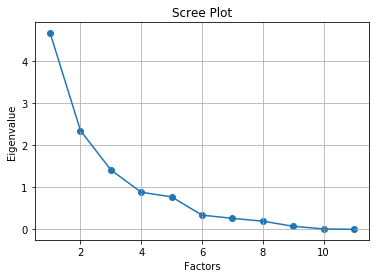

In [31]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(new_df) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,new_df.shape[1]+1),ev)
plt.plot(range(1,new_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


In [34]:
import numpy as np
fa = FactorAnalyzer(3, rotation="varimax")
fa.fit(new_df)
print(new_df.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.7))

Index(['Training', 'Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteLoad',
       'ChronicLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself'],
      dtype='object')
[[-1.23300367e-01 -4.43016192e-01  2.29139629e-04]
 [ 2.49472613e-02  4.78990031e-01 -2.72592767e-01]
 [ 1.79250040e-01  8.05767128e-01  9.14668285e-02]
 [ 3.62139112e-01  9.01719696e-01 -4.51724019e-02]
 [ 6.32902050e-01  5.70923948e-01  2.05139557e-01]
 [ 9.17386371e-01  2.89216737e-01  2.54043181e-01]
 [ 9.57676371e-01  1.78534156e-01  2.50127528e-01]
 [-8.80021790e-01  3.03388883e-02 -9.08954558e-02]
 [ 3.33783272e-01  5.05583882e-02  7.13962298e-01]
 [ 1.42689556e-01 -1.88064033e-02  8.68677070e-01]
 [-2.95039709e-01  6.33711829e-01  2.17862222e-01]]
(array([2, 3, 5, 6, 8, 9], dtype=int64), array([1, 1, 0, 0, 2, 2], dtype=int64))
